# *Title:* Predicting and Classifying The Level of Heart Disease Based on Key Risk Factors

Word count: 503

## Introduction

[Heart disease](https://www.mayoclinic.org/diseases-conditions/heart-disease/symptoms-causes/syc-20353118) describes a range of conditions that affect your heart. [Several health conditions](https://www.cdc.gov/heartdisease/risk_factors.htm), your lifestyle (eg. exercise), your age and family history can increase your risk for heart disease. The main (health) risk factors are: high blood pressure, unhealthy blood cholesterol levels, diabetes and obesity. 

When are these factors risky?
- When [blood pressure](https://www.cdc.gov/bloodpressure/about.htm#:~:text=A%20normal%20blood%20pressure%20level%20is%20less%20than%20120%2F80%20mmHg.&text=No%20matter%20your%20age%2C%20you,pressure%20in%20a%20healthy%20range) is above the normal level (120/80 mmHg)
- When [total cholesterol](https://www.medicalnewstoday.com/articles/315900#recommended-levels) levels are above 200 mg/dL
    - A person’s serum cholesterol level represents the amount of total cholesterol in their blood

[A person's maximum heart rate](https://www.medicalnewstoday.com/articles/326361#age), is calculated as 220bpm minus their age. A healthy maximum heart rate during exercise is between 50% and 85% of a person's maximum heart rate.

| Age in Years | Target exercise heart rate zone in bpm |
| --- | --- |
| 20 | 100–170 |
| 30 | 95–162 |
| 35 | 93–157 |
| 40 | 90–153 |
| 45 | 88–149 |
| 50 | 85–145 |
| 55 | 83–140 |
| 60 | 80–136 |
| 65 | 78–132 |
| 70 | 75–128 |


Using the data provided in the [Cleveland dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease), we will try to answer the question: **Given the age, levels of blood pressure, cholesterol levels and maximum heart rate of an individual patient, can we predict the presence of heart disease?** (classification)

This data was pulled from a database containing 76 attributes that describe the medical conditions of patients relating to different heart disease risk factors in four different locations. All published experiments, however, refer to using only the Cleveland dataset and a subset of 14 attributes from the 76. We will be reading this "processed" data to pick attributes. To see the full explanation of each of the attributes, please refer to the [Cleveland dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).

The "num" attribute refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. We will assume that the presence of heart disease is affirmed if the num value is a value that is not 0. 

## Preliminary exploratory data analysis

### Reading the data into R

In [1]:
#loading packages

library(tidyverse)
library(repr)
library(readxl)
library(rvest)
library(stringr)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘rvest’ was built under R version 4.0.2”
Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
─

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

heart_disease_data <- read_csv(url, col_names = FALSE)
        
#renaming columns
#refer to Cleveland dataset for full descriptions of each of the attributes
heart_disease_data <- rename(heart_disease_data,
                            age = X1, 
                            sex = X2, 
                            chest_pain = X3,
                            trestbps = X4, 
                            chol = X5, 
                            fbs = X6,
                            restecg = X7, 
                            thalach = X8, 
                            exang = X9,
                            oldpeak = X10, 
                            slope = X11, 
                            ca = X12,
                            thal = X13,
                            hd_presence = X14
                            )
heart_disease_data

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,sex,chest_pain,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd_presence
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


### Cleaning and Wrangling data

In [3]:
heart_disease_data <- mutate(heart_disease_data,
                            age = as.integer(age, na.rm = TRUE),
                            ca = as.numeric(ca, na.rm = TRUE),
                            thal = as.numeric(thal, na.rm = TRUE),
                            hd_presence = as_factor(hd_presence),
                            fbs = as.integer(fbs, na.rm = TRUE))

heart_disease_data

Warning message:
“Problem with `mutate()` input `ca`.
ℹ NAs introduced by coercion
ℹ Input `ca` is `as.numeric(ca, na.rm = TRUE)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thal`.
ℹ NAs introduced by coercion
ℹ Input `thal` is `as.numeric(thal, na.rm = TRUE)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


age,sex,chest_pain,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd_presence
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7,3
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1
38,1,3,138,175,0,0,173,0,0.0,1,NA,3,0


### Summarizing training data

In [4]:
#setting the seed to ensure consistent randomization
set.seed(1)
#splitting data into training and testing
#"heart disease" will be abbreviated to "hd"

hd_split <- initial_split(heart_disease_data, prop = 0.75, strata = hd_presence)
hd_train <- training(hd_split)
hd_test <- testing(hd_split)

#summarizing the training data by hd_presence (counting the number in each level of heart disease)
num_hd_presence <- hd_train %>%
                        group_by(hd_presence) %>%
                        summarize(n = n()) %>%
                        select(-hd_presence)
num_hd_presence

#calculating means
means <- hd_train %>%
        group_by(hd_presence) %>%
        summarize(
          mean_age = mean(age, na.rm = TRUE),
          mean_trestbps = mean(trestbps, na.rm = TRUE), #trestbps is (resting blood pressure 
                                                        #(in mm Hg on admission to the hospital))

          mean_chol = mean(chol, na.rm = TRUE), #chol is (serum cholestoral in mg/dl)
          mean_thalach = mean(thalach, na.rm = TRUE)) #thalach is maximum heart rate achieved
means

#final summary table of means of selected predictors and the number of hd_presence
summary_table <- bind_cols(means, num_hd_presence)

`summarise()` ungrouping output (override with `.groups` argument)



n
<int>
123
42
27
26
10


`summarise()` ungrouping output (override with `.groups` argument)



hd_presence,mean_age,mean_trestbps,mean_chol,mean_thalach
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,52.71545,128.8293,241.2439,157.6179
1,56.57143,133.6429,252.6905,145.8333
2,57.40741,134.6296,264.2222,135.7407
3,55.69231,132.6538,239.9231,131.6923
4,58.20000,137.1000,254.7000,142.4000


### Summary Table

In [5]:
summary_table

hd_presence,mean_age,mean_trestbps,mean_chol,mean_thalach,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,52.71545,128.8293,241.2439,157.6179,123
1,56.57143,133.6429,252.6905,145.8333,42
2,57.40741,134.6296,264.2222,135.7407,27
3,55.69231,132.6538,239.9231,131.6923,26
4,58.20000,137.1000,254.7000,142.4000,10


### NA Values

In [6]:
#calculating the number of rows in ca with missing values
#using the na.omit() function we see that 3 rows are removed - by looking at the heart_disease_data, 
#we see that the ca column is the only column with a missing value - thus it has been selected here
na_values <- hd_train %>%
filter(is.na(ca)) %>%
nrow()
#total rows with na values in hd_train
na_values

[1] 3

### Visualizing the data

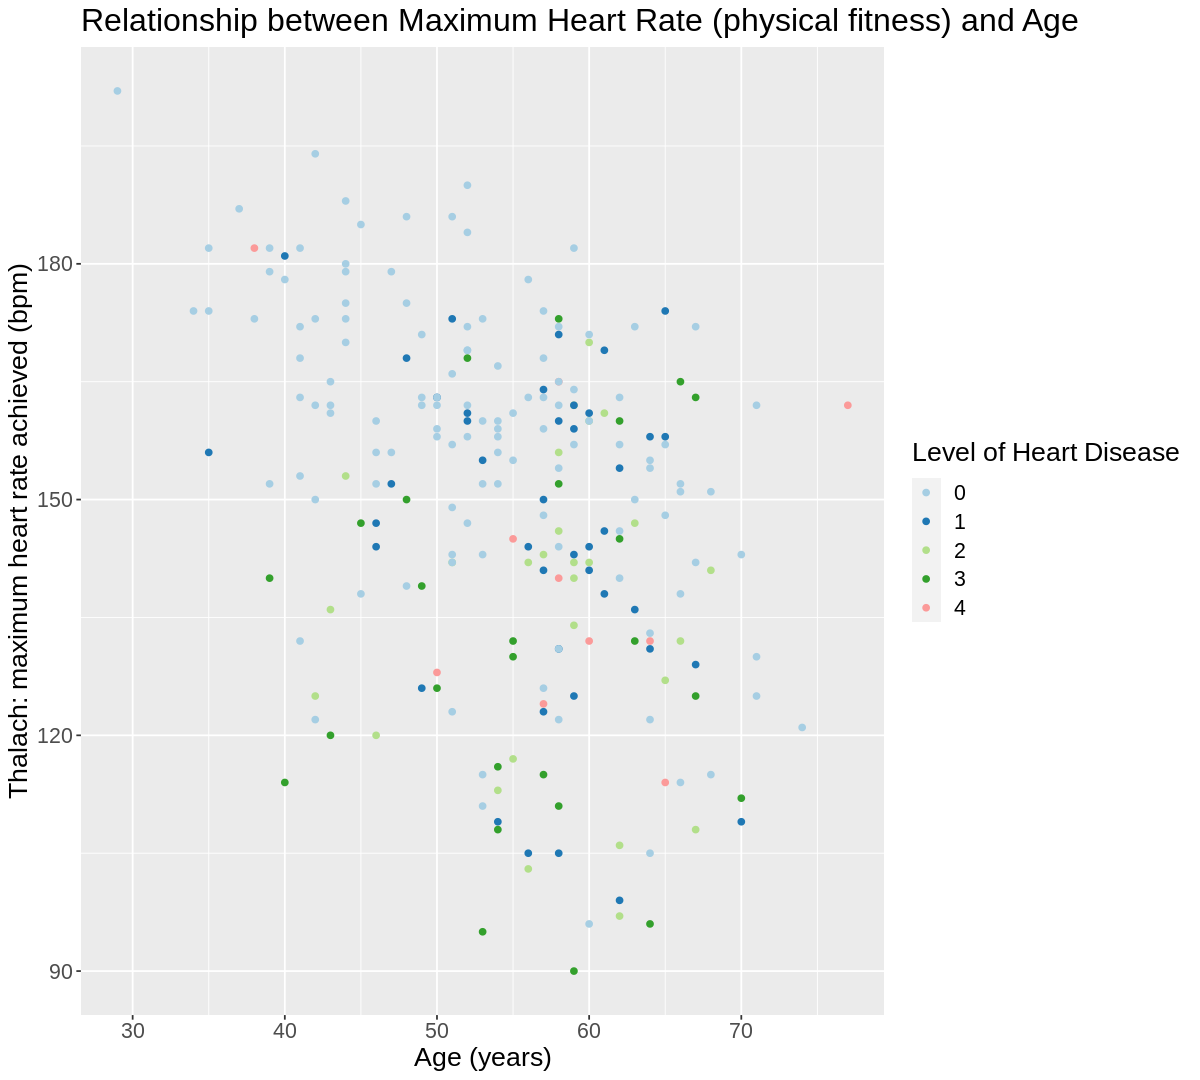

In [7]:
options(repr.plot.width = 10, repr.plot.height = 9) 

scatter_age_thalach <- ggplot(hd_train, aes(x = age, y = thalach, color = hd_presence)) +
    geom_point() +
    theme(text = element_text(size = 16))+
    labs(x = "Age (years)", y = "Thalach: maximum heart rate achieved (bpm)", color = "Level of Heart Disease")+
    ggtitle("Relationship between Maximum Heart Rate (physical fitness) and Age")+
    scale_color_brewer(palette = "Paired")
scatter_age_thalach

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



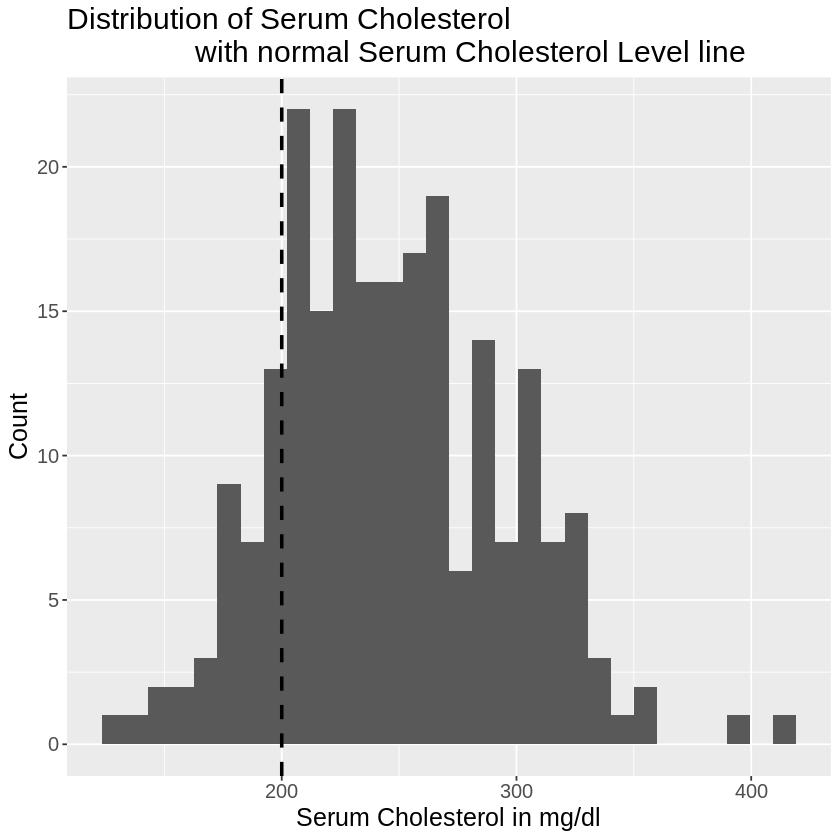

In [8]:
options(repr.plot.width = 7, repr.plot.height = 7) 

hd_train_chol <- ggplot(hd_train, aes(x = chol)) +
    geom_histogram() +
    geom_vline(xintercept = 200, linetype = "dashed", size = 1)+
    theme(text = element_text(size = 15))+
    labs(x = "Serum Cholesterol in mg/dl", y = "Count")+
    ggtitle("Distribution of Serum Cholesterol 
                with normal Serum Cholesterol Level line")
hd_train_chol

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



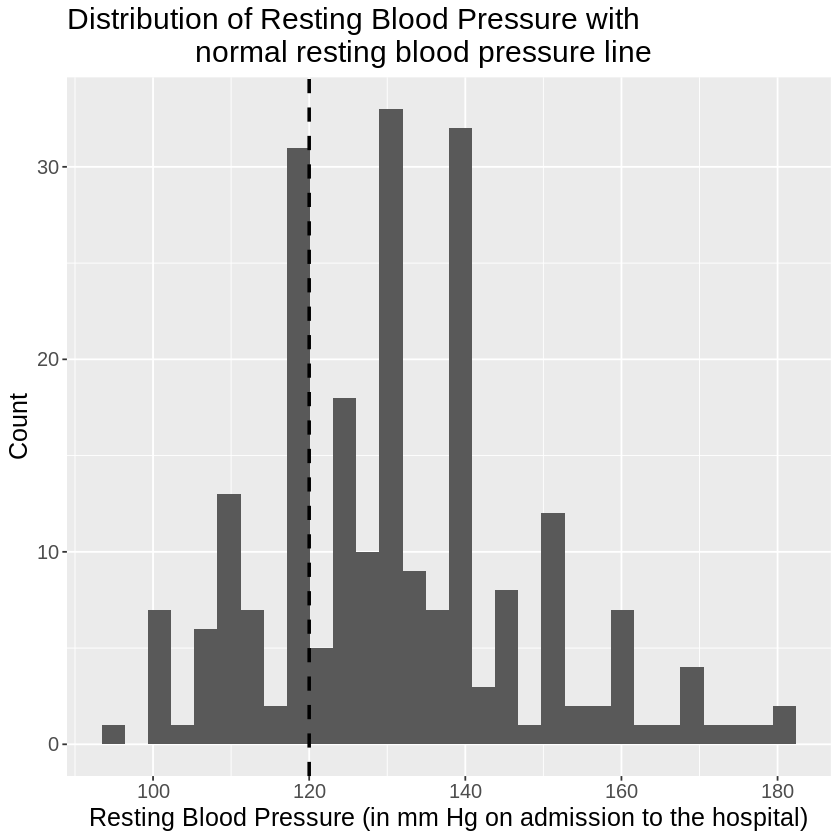

In [9]:
hd_train_trestbps <- ggplot(hd_train, aes(x = trestbps)) +
    geom_histogram()+
    geom_vline(xintercept = 120, linetype = "dashed", size = 1)+
    theme(text = element_text(size = 15))+
    labs(x = "Resting Blood Pressure (in mm Hg on admission to the hospital)", y = "Count")+
    ggtitle("Distribution of Resting Blood Pressure with 
                normal resting blood pressure line")

hd_train_trestbps

## Methods

To answer our question, we will be using the **k-nearest neighbors classification algorithm** to predict the presence of heart disease. We will use these column attributes as predictors based on our research (intro):
- age 
- trestbps (blood pressure)
- chol (cholesterol levels)
- thalach (maximum heart rate achieved to account for physical fitness)
- num (response variable)

We will also be preforming cross validation and will tune and evaluate the estimated accuracy of the classifier on the test set. Finally, we will visualize the results by creating multiple scatterplots with 2 of the 4 predictors on the axes and the colour of the points will correspond to the response variable (hd_presence). These scatterplots will hopefully show an accurate classification of individuals with and without heart disease based on the predictors.

## Expected Outcomes and Significance

We expect to find the presence of heart disease in cases where an individual is older (ie 50+), has a high level of cholesterol, low max heart rate and high blood pressure. With the findings from our study, we hope to continue to inform the prediction accuracy of determining the likelihood of an individual developing a heart disease before its onest so that they can take steps to mitigate its effects. 

To generate more and more accurate classifications, the use of more or different predictors may be explored as well (eg. see if fasting blood sugar (fbs) has an impact on heart disease presence).